<a href="https://colab.research.google.com/github/jglombitza/cifar_tutorial/blob/main/vision_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Visition transformer example for the CIFAR-10 classification task.
Classify image samples of the CIFAR-10 dataset using a transformer network

Learn more about vision transformers (ViTs) at https://arxiv.org/abs/2010.11929
Learn more about the attention mechanism, the basic building block of each transformer, at https://arxiv.org/abs/1706.03762

## CIFAR-10 Dataset
The CIFAR-10 and CIFAR-100 are labeled subsets of the 80 million tiny images dataset.
They were collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton.
see http://www.cs.toronto.edu/~kriz/cifar.html

Contains 6 files, each with 10000 shuffled images of 10 labeled classes.

The images are of size 32x32 pixels with 3 color channels (RGB).
The intensity in each channels is encoded as unsigned 8-bit integers 0...255.


Code partly adapted from https://keras.io/examples/vision/image_classification_with_vision_transformer/


In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras

layers = tf.keras.layers

## Load and preprocess CIFAR-10 data

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

print("images, shape = ", x_train.shape)
print("labels, shape = ", y_train.shape)
input_shape = (32, 32, 3)


images, shape =  (50000, 32, 32, 3)
labels, shape =  (50000, 1)


In [3]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches


def plot_patches(image, image_size, patch_size, outfile):
    plt.figure(figsize=(4, 4))
    plt.imshow(image.astype("uint8"))
    plt.axis("off")
    plt.savefig(outfile)

    patches = Patches(patch_size)(image[tf.newaxis, ...])
    print(patches.shape)
    print(f"Image size: {image_size} X {image_size}")
    print(f"Patch size: {patch_size} X {patch_size}")
    print(f"Patches per image: {patches.shape[1]}")
    print(f"Elements per patch: {patches.shape[-1]}")

    n = int(np.sqrt(patches.shape[1]))
    plt.figure(figsize=(4, 4))
    for i, patch in enumerate(patches[0]):
        ax = plt.subplot(n, n, i + 1)
        patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
        plt.imshow(patch_img.numpy().astype("uint8"))
        plt.axis("off")
    plt.show()

Let's plot the data (that is divided into patches)

(1, 64, 48)
Image size: 32 X 32
Patch size: 4 X 4
Patches per image: 64
Elements per patch: 48


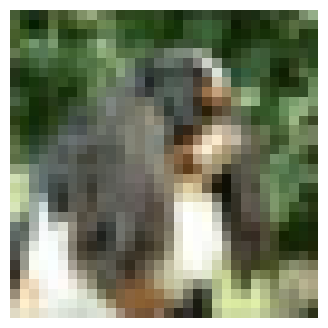

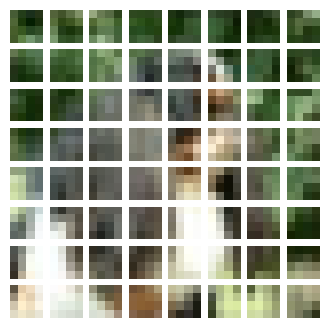

In [4]:
image_size = input_shape[0]
patch_size = 4  # Size of the patches
num_patches = (image_size // patch_size) ** 2

image = x_train[np.random.choice(range(x_train.shape[0]))]
plot_patches(image, image_size, patch_size, "image.png")


### Pre-process data
normalize each pixel and color-channel separately across all images
take 2000 images for validation from test data

In [5]:
def normalize(images):
    mean = np.mean(images, axis=0)[np.newaxis]  # shape = (1, 32, 32, 3)
    sigma = np.std(images, axis=0)[np.newaxis]  # shape = (1, 32, 32, 3)
    images_normalized = (images - mean) / sigma
    return images_normalized

# take 2000 images for validation from test data
x_train_norm = normalize(x_train)
x_test_norm = normalize(x_test)

In [6]:
y_train_onehot = tf.keras.utils.to_categorical(y_train, 10)
y_test_onehot = tf.keras.utils.to_categorical(y_test, 10)

## Define model
Add new transformer neural network here!

First start with definining the PatchEncoder --> Positional encoding.

In [7]:

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded


Then we define the feed-forward MLP that is used in each transformer block

In [8]:
def mlp(x, hidden_units, dropout_rate, transformer_units):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(transformer_units, activation=tf.nn.gelu)(x)
    return x

Finally we start setting up the transformer...

In [9]:
# Small values to enable fast training -> will not achieve good performance

projection_dim = 32  # Size of transformer layers (d)
transformer_layers = 4  # number of transformer blocks
num_heads = 4  # remember that d has to be dividable by num_heads (h)
mlp_head_units = [128]  # Size of MLP hidden layer

In [ ]:
# Build model
inputs = layers.Input(shape=input_shape)
patches = Patches(patch_size)(inputs)
# Encode patches.
encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

# Construct multiple layers of the Transformer block.
for _ in range(transformer_layers):

    x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)  # Layernorm 1
    # TASK: perform attention
    # make use of "num_heads" and "projection_dim"
    # perfrom self attention using the MultiHeadAttention layer.
    attention_output = ....

    x2 = layers.Add()([attention_output, encoded_patches])  # Residual connection
    x3 = layers.LayerNormalization(epsilon=1e-6)(x2)  # Layernorm 2

    # TASK: add MLP model
    x3 = ....
    encoded_patches = layers.Add()([x3, x2])


representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
representation = layers.Flatten()(representation)
representation = layers.Dropout(0.3)(representation)

# Create output of the model
# Add a Dense, Dropout, and a final classification layer (remember num_classes = 10 in CIFAR-10)
output = ...

# Build the Keras model.
model = keras.Model(inputs=inputs, outputs=output, name="vit")

## Prepare model for training

In [ ]:
# setup the optimizer
learning_rate = 0.001
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

In [ ]:
# compile the model
model.compile(
    optimizer=optimizer,
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[keras.metrics.CategoricalAccuracy(name="accuracy"),
             keras.metrics.TopKCategoricalAccuracy(3, name="top-3-accuracy")])

model.summary()

# Perform training

Transformer need lots of data.
Thus, expect the CNN to perform better than transformers that are not pre-trained.

In [ ]:
batch_size = 32
num_epochs = 20

history = model.fit(
    x=x_train_norm,
    y=y_train_onehot,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_split=0.1)


## Plot training curves

### Loss

In [ ]:
fig, ax = plt.subplots(1)
nb_epochs = np.arange(len(history.history["loss"]))
ax.plot(nb_epochs, history.history["loss"], label="train")
ax.plot(nb_epochs, history.history["val_loss"], label="validation")
ax.legend()
ax.set(xlabel="epoch", ylabel="loss")

### Accuracy

In [ ]:
fig, ax = plt.subplots(1)
nb_epochs = np.arange(len(history.history["accuracy"]))
ax.plot(nb_epochs, history.history["accuracy"], label="training")
ax.plot(nb_epochs, history.history["val_accuracy"], label="validation")
ax.legend()
ax.set(xlabel="epoch", ylabel="accuracy")

## Plot classifications using the test set
calculate predictions for test set and convert back to class labels (0-9)


In [ ]:
def plot_prediction(X, Y, Y_predict, fname=False):
    labels = np.array(["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"])

    """
    Plot image X along with predicted probabilities Y_predict.
    X: CIFAR image, shape = (32, 32, 3)
    Y: CIFAR label, one-hot encoded, shape = (10)
    Y_predict: predicted probabilities, shape = (10)
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

    # plot image
    ax1.imshow(X.astype("uint8"), origin="upper")
    ax1.set(xticks=[], yticks=[])

    # plot probabilities
    ax2.barh(np.arange(10), Y_predict, align="center")
    ax2.set(xlim=(0, 1), xlabel="Score", yticks=[])
    for i in range(10):
        c = "red" if (i == np.argmax(Y)) else "black"
        ax2.text(0.05, i, labels[i].capitalize(), ha="left", va="center", color=c)


In [ ]:
y_predict = model.predict(x_test_norm, batch_size=128)

y_predict_cl = np.argmax(y_predict, axis=1)
y_test_cl = np.argmax(y_test_onehot, axis=1)

In [ ]:
m = y_predict_cl == y_test_cl
i0 = np.arange(10000)[~m]  # misclassified images
i1 = np.arange(10000)[m]  # correctly classified images


#### Plot first 5 false classifications

In [ ]:
fname = "false_%i_{}.png".format(model.name)
for i in i0[0:5]:
    plot_prediction(x_test[i], y_test_onehot[i], y_predict[i], fname=fname % i)



#### Plot first 5 correct classifications

In [ ]:
fname = "correct_%i_{}.png".format(model.name)
for i in i1[0:5]:
    plot_prediction(x_test[i], y_test_onehot[i], y_predict[i], fname=fname % i)